In [1]:
# ! rm -r runs

import pickle
import random
from collections import namedtuple

import gym
import gym_point
import numpy as np
import ptan
import torch
print(torch.__version__)
import torch.optim as optim
from ptan.agent import float32_preprocessor

from util import PGN, RewardNet

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

1.7.0


In [2]:
GAMMA = 0.99
LEARNING_RATE = 0.001
EPISODES_TO_TRAIN = 4
DEMO_BATCH = 100
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

EpisodeStep = namedtuple('EpisodeStep', field_names=['state', 'action', 'reward', 'next_state'])
Trajectory = namedtuple('Trajectory', field_names=['prob', 'episode_steps'])

In [3]:
def calc_qvals(rewards):
    res = []
    sum_r = 0.0
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    return list(reversed(res))


# def process_demonstrations(demo_samples):
#     traj_states, traj_actions, traj_qvals, traj_prob = [], [], [], []
#     for traj in demo_samples:
#         states, actions, rewards, qvals = [], [], [], []
#         traj_prob.append(traj.prob)
#         for step in traj.episode_steps:
#             states.append(step.state)
#             actions.append(step.action)
#             rewards.append(step.reward)
#         qvals.extend(calc_qvals(rewards))

#         traj_states.append(states)
#         traj_actions.append(actions)
#         traj_qvals.append(qvals)
#     traj_states = np.array(traj_states, dtype=np.object)
#     traj_actions = np.array(traj_actions, dtype=np.object)
#     traj_qvals = np.array(traj_qvals, dtype=np.object)
#     traj_prob = np.array(traj_prob, dtype=np.float)
#     return {'states': traj_states, 'actions': traj_actions, 'qvals': traj_qvals, 'traj_probs': traj_prob}

def process_demonstrations(demo_samples):
    traj_states, traj_actions = [], []
    for traj in demo_samples:
        states, actions = [], []

        for step in traj.episode_steps:
            states.append(step.state)
            actions.append(step.action)

        traj_states.append(states)
        traj_actions.append(actions)
    traj_states = np.array(traj_states, dtype=np.object)
    traj_actions = np.array(traj_actions, dtype=np.object)
    return {'states': traj_states, 'actions': traj_actions}

In [4]:
env = gym.make('PointContinuousEnv-v0')
agent_net = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net = RewardNet(env.observation_space.shape[0] + 1)
# reward_net = RewardNet(2)
agent = ptan.agent.PolicyAgent(agent_net, preprocessor=float32_preprocessor, apply_softmax=True)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)
optimizer_agent = optim.Adam(agent_net.parameters(), lr=LEARNING_RATE)
optimizer_reward = optim.Adam(reward_net.parameters(), lr=1e-2, weight_decay=1e-4)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


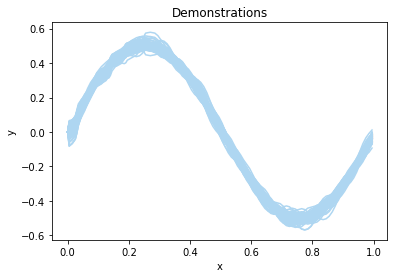

In [5]:
## Generate Expert Demonstrations 
# x = [x, y, xdot, ydot]
# xdot = [xdot, ydot, xddot, yddot]
# Plotting variables

Xdes = []
Ydes = []
Acc = []
        
def control(s, timer, dt=0.01):
    Kp = -100   # Controller gains 
    Kd = -3
    
    xdes = timer + dt
    Xdes.append(xdes)
    
    amp_noise = np.random.normal(0, 0.001, 1)
    x_noise = np.random.normal(0, 0.1, 1)
    freq_noise = np.random.uniform(0.95, 1.1, 1)
    
    noise = np.random.uniform(-0.01,0.01)
#     ydes = -0.5*np.sin(-6.28*(timer+dt)/freq_noise + x_noise) + amp_noise
    ydes = -0.5*np.sin(-6.28*(timer+dt))
    Ydes.append(ydes)
    ex = s[0] - xdes
    ey = s[1] - ydes
    ex_dot = s[2]
    ey_dot = s[3]
    ax = np.array(np.round(Kp*ex + Kd*ex_dot))
    ay = np.array(np.round(Kp*ey + Kd*ey_dot))
    np.clip(ax, -1, 1, out=ax)
    np.clip(ay, -1, 1, out=ay)
    return (ax, ay) 

def encode_action(ax, ay):
    if ax == -1 and ay == -1:
        action = 0
    elif ax == -1 and ay == 0:
        action = 1
    elif ax == -1 and ay == 1:
        action = 2
    elif ax == 0 and ay == -1:
        action = 3
    elif ax == 0 and ay == 0:
        action = 4
    elif ax == 0 and ay == 1:
        action = 5
    elif ax == 1 and ay == -1:
        action = 6
    elif ax == 1 and ay == 0:
        action = 7
    elif ax == 1 and ay == 1:
        action = 8
    return action

def get_demonstrations(Ndemo=50):
    dt = 0.01  # Discrete time step
    demo_states = []
    demo_actions = []

    for idemo in range(Ndemo):
        state = env.reset()

        # Storage variables
        XStore = [state.copy()] # State trajectory
        AStore = [] # initial action 1, 1 # Action trajectory
        RStore = [] # Reward trajectory
        TStore = []  # Time trajectory
        AxStore = []
        AyStore = []
        # Initializations
        done = False 
        i = 1
        timer = 0

        while not done:
            timer = i*dt
            state[1] += np.random.normal(0, 0.03, 1)
            ax, ay = control(state, timer)
            action = encode_action(ax, ay)
            next_state, reward, done, info = env.step(action)
                            
            state = next_state.copy()
            
            # Store variables
            XStore.append(state.copy())
            AStore.append(action)
            AxStore.append(ax)
            AyStore.append(ay)
            RStore.append(reward)
            TStore.append(timer)
            Acc.append([ax,ay])
    
            i += 1
            
        if info == 'out_of_margin':
            continue

        # sample = [XStore, AStore, RStore]
        demo_states.append(XStore[:-1])
        demo_actions.append(AStore)
        # demo_trajs.append(sample)
        plt.plot(np.array(XStore)[:,0], np.array(XStore)[:,1], '#aed6f1')
#         plt.plot(np.array(XStore)[:,0], np.array(XStore)[:,1])
#         plt.plot(np.array(Xdes), np.array(Ydes))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Demonstrations')
        
#         plt.figure()
#         plt.plot(np.array(TStore), np.array(AxStore[:-1]))
#         plt.xlabel('t')
#         plt.ylabel('ax')
        
#         plt.figure()
#         plt.plot(np.array(TStore), np.array(AyStore[:-1]))
#         plt.xlabel('t')
#         plt.ylabel('ay')
        
    # demo_trajs = np.asarray(demo_trajs)
    # print("Total Samples: ", len(demo_trajs))
    # print("Demonstrations Shape: ", demo_trajs.shape, "[no. of samples, {State, Action, Reward}, No. of points]")
    keys = ['states', 'actions']
    demonstrations = dict.fromkeys(keys, None)
    demonstrations['states'] = demo_states
    demonstrations['actions'] = demo_actions
    return demonstrations

demonstrations = get_demonstrations(100)

In [6]:
## Testing Demonstration

def test_demonstration(demonstrations):
    for i in range(0,100, 50):
        state = env.reset()
        Reward = 0
        done = False
        j = 0
        while not done:
            env.render()
            action = demonstrations['actions'][i][j]
            new_state, reward, done, _ = env.step(int(action))
            Reward += reward 
            j += 1 
        print("Test case: ", i,  ' Reward: ', Reward)

test_demonstration(demonstrations)

Test case:  0  Reward:  100
Test case:  50  Reward:  100


In [7]:
# with open('demonstrations.list.pkl', 'rb') as f:
#     demonstrations = pickle.load(f)
# assert (len(demonstrations) > DEMO_BATCH)
# print(f'Number of demonstrations: {len(demonstrations)}')
# demonstrations = process_demonstrations(demonstrations) 
# dict_keys(['states', 'actions', 'qvals', 'traj_probs'])

In [8]:
# States[100 x 500 x 4]
# Actions[100 x 500 x 1]
# demonstrations['states'] # Array of lists of actions
# demonstrations['actions'] # Array of lists of array of states

In [9]:
total_rewards = []
step_idx = 0
done_episodes = 0

batch_episodes = 0
batch_states, batch_actions, batch_qvals = [], [], []
cur_rewards = []
loss_rwd = 0.

for step_idx, exp in enumerate(exp_source):
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    x = torch.cat([float32_preprocessor(exp.state), float32_preprocessor([int(exp.action)])]).view(1, -1)
    reward = reward_net(x)
    cur_rewards.append(reward.item())

    if exp.last_state is None:
        batch_qvals.extend(calc_qvals(cur_rewards))
        cur_rewards.clear()
        batch_episodes += 1

    new_rewards = exp_source.pop_total_rewards()
    if new_rewards:
        done_episodes += 1
        reward = new_rewards[0]
        total_rewards.append(reward)
        mean_rewards = float(np.mean(total_rewards[-100:]))
        writer.add_scalar('reward', reward, done_episodes)
        writer.add_scalar('mean_reward', mean_rewards, done_episodes)
        writer.add_scalar('loss_rwd', loss_rwd, done_episodes)        
        print(f'{step_idx}: reward: {reward:6.2f}, mean_100: {mean_rewards:6.2f}, '
              f'episodes: {done_episodes}, reward function loss: {loss_rwd:6.4f}')
        
        ## Tensorboard logging 
        if done_episodes%100 == 0 or mean_rewards>=80:
            S1 = np.linspace(0, 1, 100)
            S2 = np.linspace(-1, 1, 100)
            S3 = 0*S1
            S4 = 0*S1
            A1 = np.ones(100)
            Reward = np.zeros((100,100))
            for i in range(100):
                for j in range(100):
                    state = [S1[i], S2[j], 0, 0]
                    action = 1
                    x = torch.cat([float32_preprocessor(state), float32_preprocessor([int(action)])]).view(1, -1)
                    r = reward_net(x)
                    Reward[i,j] = r
                    
            X, Y = np.meshgrid(S1, S2)
            Z = Reward
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                            cmap='viridis', edgecolor='none')
            ax.set_title('surface');
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z');
            ax.view_init(azim=0, elev=90)
            writer.add_figure('mesh', fig, global_step=done_episodes/100)
        
        if mean_rewards >= 80:
            print(f'Solved in {step_idx} steps and {done_episodes} episodes!')
            torch.save(agent_net.state_dict(), 'cartpole_learner.mod')
            torch.save(reward_net.state_dict(), 'cartpole-v1_reward_func.mod')
            break

    if batch_episodes < EPISODES_TO_TRAIN:
        continue

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)
  
    for rf_i in range(10):
        # reward function learning
        demo_states = np.array(demonstrations['states'])
        demo_actions = np.array(demonstrations['actions'])
        selected = np.random.choice(len(demonstrations['states']), DEMO_BATCH)
        demo_states = demo_states[selected]
        demo_actions = demo_actions[selected]
        demo_batch_states, demo_batch_actions = [], []
    
        for idx in range(len(demo_states)):
            demo_batch_states.extend(demo_states[idx])
            demo_batch_actions.extend(demo_actions[idx])
        
        demo_batch_states = torch.FloatTensor(demo_batch_states)
        demo_batch_actions = torch.FloatTensor(demo_batch_actions)
        
        D_demo = torch.cat([demo_batch_states, demo_batch_actions.view(-1, 1)], dim=-1)
        D_samp = torch.cat([states_v, batch_actions_t.float().view(-1, 1)], dim=-1)
        D_samp = torch.cat([D_demo, D_samp])
        
        # dummy importance weights - fix later
        z = torch.ones((D_samp.shape[0], 1))

        # objective
        D_demo_out = reward_net(D_demo)
        D_samp_out = reward_net(D_samp)
        D_samp_out = z * torch.exp(D_samp_out)
        loss_rwd = torch.mean(D_demo_out) - torch.log(torch.mean(D_samp_out))
        loss_rwd = -10000*loss_rwd  # for maximization

        # update parameters
        optimizer_reward.zero_grad()
        loss_rwd.backward()
        optimizer_reward.step()

    # agent
    optimizer_agent.zero_grad()
    logits_v = agent_net(states_v)
    log_prob_v = torch.log_softmax(logits_v, dim=1)
    # REINFORCE
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = log_prob_actions_v.mean()

    loss_v.backward()
    optimizer_agent.step()

    batch_episodes = 0
    batch_states.clear()
    batch_actions.clear()
    batch_qvals.clear()
env.close()
writer.close()

100: reward: -92.00, mean_100: -92.00, episodes: 1, reward function loss: 0.0000
200: reward: -88.00, mean_100: -90.00, episodes: 2, reward function loss: 0.0000
300: reward: -92.00, mean_100: -90.67, episodes: 3, reward function loss: 0.0000
400: reward: -88.00, mean_100: -90.00, episodes: 4, reward function loss: -192.8937
500: reward: -68.00, mean_100: -85.60, episodes: 5, reward function loss: -192.8937
600: reward: -78.00, mean_100: -84.33, episodes: 6, reward function loss: -192.8937
700: reward: -88.00, mean_100: -84.86, episodes: 7, reward function loss: -192.8937
800: reward: -92.00, mean_100: -85.75, episodes: 8, reward function loss: -186.3432
900: reward: -90.00, mean_100: -86.22, episodes: 9, reward function loss: -186.3432
1000: reward: -92.00, mean_100: -86.80, episodes: 10, reward function loss: -186.3432
1100: reward: -92.00, mean_100: -87.27, episodes: 11, reward function loss: -186.3432
1200: reward: -94.00, mean_100: -87.83, episodes: 12, reward function loss: -183.

10000: reward: -92.00, mean_100: -84.76, episodes: 100, reward function loss: -243.7860
10100: reward: -64.00, mean_100: -84.48, episodes: 101, reward function loss: -243.7860
10200: reward: -90.00, mean_100: -84.50, episodes: 102, reward function loss: -243.7860
10300: reward: -94.00, mean_100: -84.52, episodes: 103, reward function loss: -243.7860
10400: reward: -92.00, mean_100: -84.56, episodes: 104, reward function loss: -245.9347
10500: reward: -64.00, mean_100: -84.52, episodes: 105, reward function loss: -245.9347
10600: reward: -92.00, mean_100: -84.66, episodes: 106, reward function loss: -245.9347
10700: reward: -88.00, mean_100: -84.66, episodes: 107, reward function loss: -245.9347
10800: reward: -90.00, mean_100: -84.64, episodes: 108, reward function loss: -243.0367
10900: reward: -74.00, mean_100: -84.48, episodes: 109, reward function loss: -243.0367
11000: reward: -70.00, mean_100: -84.26, episodes: 110, reward function loss: -243.0367
11100: reward: -92.00, mean_100:

19600: reward: -92.00, mean_100: -84.92, episodes: 196, reward function loss: -246.1243
19700: reward: -92.00, mean_100: -84.92, episodes: 197, reward function loss: -246.1243
19800: reward: -92.00, mean_100: -85.02, episodes: 198, reward function loss: -246.1243
19900: reward: -92.00, mean_100: -85.32, episodes: 199, reward function loss: -246.1243
20000: reward: -84.00, mean_100: -85.24, episodes: 200, reward function loss: -246.1213
20100: reward: -86.00, mean_100: -85.46, episodes: 201, reward function loss: -246.1213
20200: reward: -92.00, mean_100: -85.48, episodes: 202, reward function loss: -246.1213
20300: reward: -92.00, mean_100: -85.46, episodes: 203, reward function loss: -246.1213
20400: reward: -78.00, mean_100: -85.32, episodes: 204, reward function loss: -246.1231
20500: reward: -90.00, mean_100: -85.58, episodes: 205, reward function loss: -246.1231
20600: reward: -88.00, mean_100: -85.54, episodes: 206, reward function loss: -246.1231
20700: reward: -92.00, mean_100:

29200: reward: -90.00, mean_100: -86.62, episodes: 292, reward function loss: -246.1255
29300: reward: -92.00, mean_100: -86.62, episodes: 293, reward function loss: -246.1255
29400: reward: -92.00, mean_100: -86.68, episodes: 294, reward function loss: -246.1255
29500: reward: -92.00, mean_100: -86.68, episodes: 295, reward function loss: -246.1255
29600: reward: -92.00, mean_100: -86.68, episodes: 296, reward function loss: -246.1272
29700: reward: -84.00, mean_100: -86.60, episodes: 297, reward function loss: -246.1272
29800: reward: -92.00, mean_100: -86.60, episodes: 298, reward function loss: -246.1272
29900: reward: -66.00, mean_100: -86.34, episodes: 299, reward function loss: -246.1272
30000: reward: -84.00, mean_100: -86.34, episodes: 300, reward function loss: -246.1261
30100: reward: -90.00, mean_100: -86.38, episodes: 301, reward function loss: -246.1261
30200: reward: -86.00, mean_100: -86.32, episodes: 302, reward function loss: -246.1261
30300: reward: -90.00, mean_100:

38800: reward: -92.00, mean_100: -87.74, episodes: 388, reward function loss: -246.1266
38900: reward: -92.00, mean_100: -87.74, episodes: 389, reward function loss: -246.1266
39000: reward: -88.00, mean_100: -88.14, episodes: 390, reward function loss: -246.1266
39100: reward: -92.00, mean_100: -88.20, episodes: 391, reward function loss: -246.1266
39200: reward: -80.00, mean_100: -88.10, episodes: 392, reward function loss: -246.1272
39300: reward: -84.00, mean_100: -88.02, episodes: 393, reward function loss: -246.1272
39400: reward: -92.00, mean_100: -88.02, episodes: 394, reward function loss: -246.1272
39500: reward: -92.00, mean_100: -88.02, episodes: 395, reward function loss: -246.1272
39600: reward: -92.00, mean_100: -88.02, episodes: 396, reward function loss: -246.1261
39700: reward: -92.00, mean_100: -88.10, episodes: 397, reward function loss: -246.1261
39800: reward: -86.00, mean_100: -88.04, episodes: 398, reward function loss: -246.1261
39900: reward: -88.00, mean_100:

KeyboardInterrupt: 